In [1]:
using Pkg
Pkg.activate("comparisons/")
import locaTE
import locaTE.prec_rec_rate 
import locaTE.aupr
import locaTE.ep
using Glob
using NPZ
using OptimalTransport
using StatsBase
using Plots
using LinearAlgebra
using ProgressMeter
using NaNMath
using Suppressor
using ThreadTools
using DataFrames
using ArgParse 
include("comparisons/process_outputs_util.jl")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/comparisons`


process_genie3 (generic function with 1 method)

In [2]:
using EvalMetrics

In [3]:
DATA_DIR = "../../data/simulated/Synthetic_1000/dyn-SW"
# DATA_DIR = "../../../../stephenz/sc-causal-grn/manuscript/data_simulation/data/archived/Synthetic_1000/dyn-BFStrange"
# DATA_DIR = "../../data/simulated/Synthetic_1000_gridsearch/dyn-BFStrange"
# DATA_DIR = "../../data/simulated/Synthetic_1000_gridsearch/dyn-SW"

"../../data/simulated/Synthetic_1000/dyn-SW"

In [4]:
dataset_dirs = glob([DATA_DIR, r"dyn.*-1000-[0-9]*$", ])
sim = split(split(dataset_dirs[1], r"-1$")[1], "/")[end]
datasets = tmap(process_dataset, dataset_dirs)
Ng = size(first(datasets)["X"], 2)
Nc = size(first(datasets)["X"], 1)

1000

In [ ]:
job_data = tmap(x -> load_job_data(x, Ng; locate_what = "G_cdf", cespgrn_what = "G"), dataset_dirs);
job_scores_aupr = tmap(((x, y), ) -> score_job_outputs(x["outputs"], y; what = :aupr), zip(job_data, datasets));
job_scores_ep = tmap(((x, y), ) -> score_job_outputs(x["outputs"], y; what = :ep), zip(job_data, datasets));

In [ ]:
job_data_static = tmap(x -> load_job_data(x, Ng; locate_what = "G_static_cdf", cespgrn_what = "G_static", static = true), dataset_dirs);

In [ ]:
s = "locaTE_velo_dot"

In [ ]:
J_static = map(x -> mean(x["J"]; dims = 1)[1, :, :] .> 0.05, datasets);
scores_all_static_aupr = [[process_locate(x, J_static[j])[2] for x in job_data_static[j]["outputs"][s]] for j = 1:length(job_data_static)];
scores_all_static_ep = [[process_locate(x, J_static[j]; what = :ep)[2] for x in job_data_static[j]["outputs"][s]] for j = 1:length(job_data_static)];

In [ ]:
locaTE_params = Dict("tau" => sort(unique(map(x -> x[1], first(job_data)["params"]["locaTE_velo_dot"]))), 
                "lambda1" => sort(unique(map(x -> x[2], first(job_data)["params"]["locaTE_velo_dot"]))), 
                "lambda2" => sort(unique(map(x -> x[3], first(job_data)["params"]["locaTE_velo_dot"]))))

In [ ]:
param_names = ["tau", "lambda1", "lambda2"];
scores_all_aupr = map(x -> x[s], job_scores_aupr)
scores_all_ep = map(x -> x[s], job_scores_ep)
params_all = map(x -> x["params"][s], job_data);

In [ ]:
function _aggregate(x, p)
    scores_agg = zeros(([length(locaTE_params[v]) for v in param_names]...));
    for (s, (p1, p2, p3)) in zip(x, p)
        scores_agg[findfirst(locaTE_params["tau"] .== p1),
                    findfirst(locaTE_params["lambda1"] .== p2),
                    findfirst(locaTE_params["lambda2"] .== p3)] = s
    end
    scores_agg
end

In [22]:
scores_agg_all_aupr = [_aggregate(x, y) for (x, y) in zip(scores_all_aupr, params_all)];
scores_agg_all_ep = [_aggregate(x, y) for (x, y) in zip(scores_all_ep, params_all)];
scores_agg_all_static_aupr = [_aggregate(x, y) for (x, y) in zip(scores_all_static_aupr, params_all)];
scores_agg_all_static_ep = [_aggregate(x, y) for (x, y) in zip(scores_all_static_ep, params_all)];
scores_agg_mean_aupr = mean(scores_agg_all_aupr);
scores_agg_mean_ep = mean(scores_agg_all_ep);
scores_agg_mean_static_aupr = mean(scores_agg_all_static_aupr);
scores_agg_mean_static_ep = mean(scores_agg_all_static_ep);

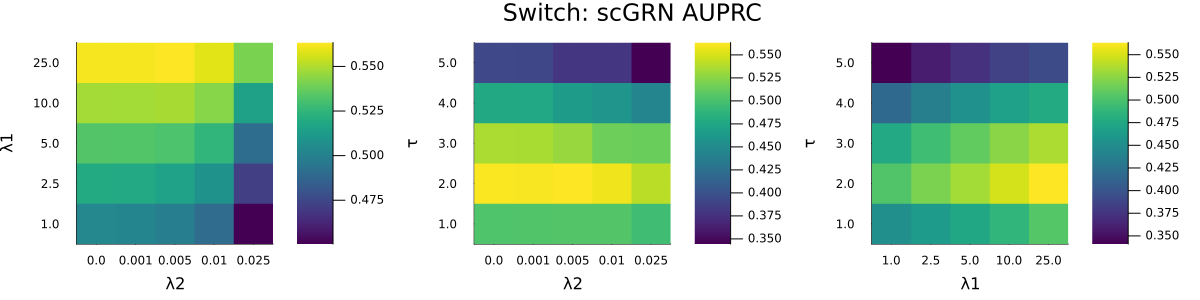

In [23]:
plt1=heatmap(maximum(scores_agg_mean_aupr; dims = 1)[1, :, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "λ1", 
    yticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_aupr)
);
plt2=heatmap(maximum(scores_agg_mean_aupr; dims = 2)[:, 1, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_aupr)
);
plt3=heatmap(maximum(scores_agg_mean_aupr; dims = 3)[:, :, 1], 
    xlabel = "λ1", 
    xticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis,
    # clim = extrema(scores_agg_mean_aupr)
);

plt=plot(plt1, plt2, plt3; layout = (1, 3), size = (1200, 300), bottom_margin = 7.5*Plots.mm, top_margin = 5*Plots.mm,
        plot_title = "Switch: scGRN AUPRC")
savefig("switch_param_sweep_scgrn_aupr.pdf")
plt

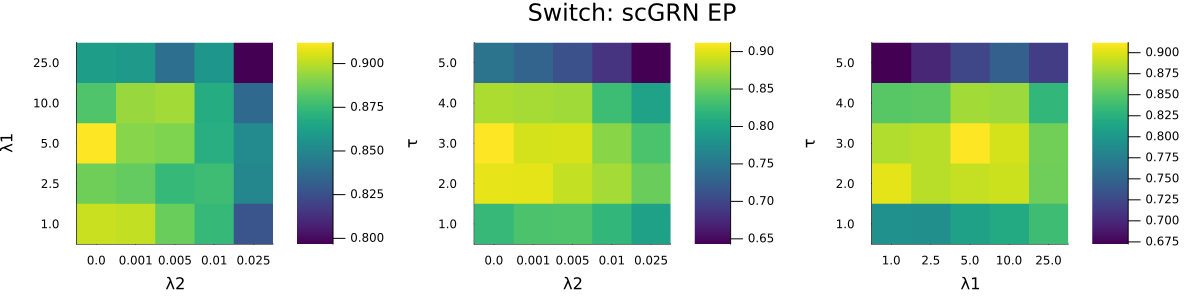

In [24]:
plt1=heatmap(maximum(scores_agg_mean_ep; dims = 1)[1, :, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "λ1", 
    yticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_ep)
);
plt2=heatmap(maximum(scores_agg_mean_ep; dims = 2)[:, 1, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_ep)
);
plt3=heatmap(maximum(scores_agg_mean_ep; dims = 3)[:, :, 1], 
    xlabel = "λ1", 
    xticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis,
    # clim = extrema(scores_agg_mean_ep)
);

plt=plot(plt1, plt2, plt3; layout = (1, 3), size = (1200, 300), bottom_margin = 7.5*Plots.mm, top_margin = 5*Plots.mm,
        plot_title = "Switch: scGRN EP")
savefig("switch_param_sweep_scgrn_ep.pdf")
plt

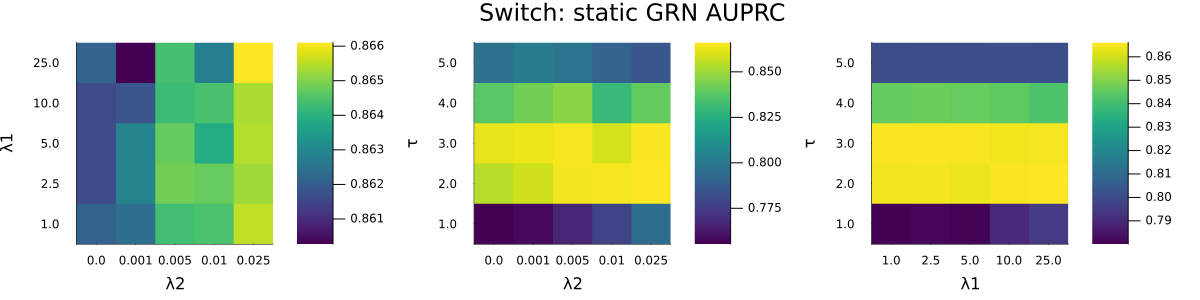

In [25]:
plt1=heatmap(maximum(scores_agg_mean_static_aupr; dims = 1)[1, :, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "λ1", 
    yticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    left_margin = 5*Plots.mm, c = :viridis,
    # clim = extrema(scores_agg_mean_static_aupr)
);
plt2=heatmap(maximum(scores_agg_mean_static_aupr; dims = 2)[:, 1, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_static_aupr)
);
plt3=heatmap(maximum(scores_agg_mean_static_aupr; dims = 3)[:, :, 1], 
    xlabel = "λ1", 
    xticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_static_aupr)
);

plt=plot(plt1, plt2, plt3; layout = (1, 3), size = (1200, 300), bottom_margin = 7.5*Plots.mm, top_margin = 5*Plots.mm,
        plot_title = "Switch: static GRN AUPRC", )
savefig("switch_param_sweep_static_aupr.pdf")
plt

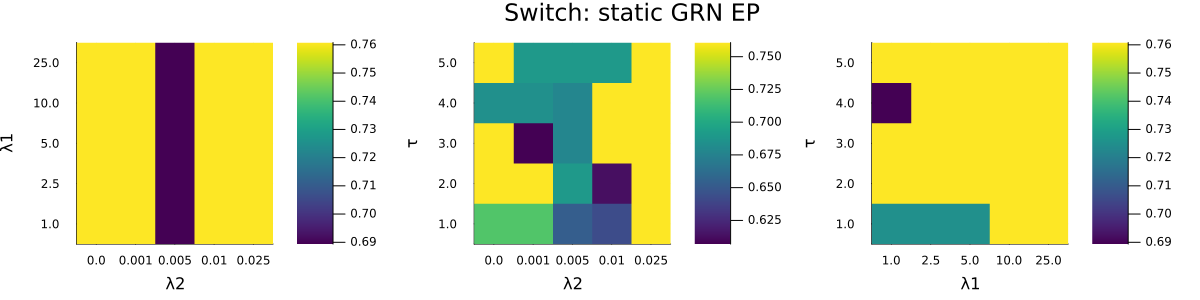

In [26]:
plt1=heatmap(maximum(scores_agg_mean_static_ep; dims = 1)[1, :, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "λ1", 
    yticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    left_margin = 5*Plots.mm, c = :viridis,
    # clim = extrema(scores_agg_mean_static_ep)
);
plt2=heatmap(maximum(scores_agg_mean_static_ep; dims = 2)[:, 1, :], 
    xlabel = "λ2", 
    xticks = (1:length(locaTE_params["lambda2"]), locaTE_params["lambda2"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_static_ep)
);
plt3=heatmap(maximum(scores_agg_mean_static_ep; dims = 3)[:, :, 1], 
    xlabel = "λ1", 
    xticks = (1:length(locaTE_params["lambda1"]), locaTE_params["lambda1"]), 
    ylabel = "τ", 
    yticks = (1:length(locaTE_params["tau"]), locaTE_params["tau"]), 
    left_margin = 5*Plots.mm, c = :viridis, 
    # clim = extrema(scores_agg_mean_static_ep)
);

plt=plot(plt1, plt2, plt3; layout = (1, 3), size = (1200, 300), bottom_margin = 7.5*Plots.mm, top_margin = 5*Plots.mm,
        plot_title = "Switch: static GRN EP", )
savefig("switch_param_sweep_static_ep.pdf")
plt